<a href="https://colab.research.google.com/github/JuniusKareth/Tugas_Alpro2-/blob/main/Classification_Rice_Using_VGG_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import google drive


In [ ]:
import os
from google.colab import drive
MOUNTPOINT = '/content/gdrive'
DATADIR = os.path.join(MOUNTPOINT, 'Data', 'myfolder')
drive.mount(MOUNTPOINT)

Mounted at /content/gdrive


## import library yang digunakan


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

## menampilkan dataset


In [ ]:
# !ls /content
# !ls /content/gdrive
# !ls /content/gdrive/MyDrive
!ls /content/gdrive/MyDrive/Beras/Bulog/
!ls /content/gdrive/MyDrive/Beras/Bulog/Train/
!ls /content/gdrive/MyDrive/Beras/Bulog/Train/Bagus/
!ls /content/gdrive/MyDrive/Beras/Bulog/Train/Jelek/

Train
Bagus  Jelek
100.jpg  115.jpg  12.jpg   144.jpg  159.jpg  19.jpg  33.jpg  48.jpg  62.jpg  77.jpg  91.jpg
101.jpg  116.jpg  130.jpg  145.jpg  15.jpg   1.jpg   34.jpg  49.jpg  63.jpg  78.jpg  92.jpg
102.jpg  117.jpg  131.jpg  146.jpg  160.jpg  20.jpg  35.jpg  4.jpg   64.jpg  79.jpg  93.jpg
103.jpg  118.jpg  132.jpg  147.jpg  161.jpg  21.jpg  36.jpg  50.jpg  65.jpg  7.jpg   94.jpg
104.jpg  119.jpg  133.jpg  148.jpg  162.jpg  22.jpg  37.jpg  51.jpg  66.jpg  80.jpg  95.jpg
105.jpg  11.jpg   134.jpg  149.jpg  163.jpg  23.jpg  38.jpg  52.jpg  67.jpg  81.jpg  96.jpg
106.jpg  120.jpg  135.jpg  14.jpg   164.jpg  24.jpg  39.jpg  53.jpg  68.jpg  82.jpg  97.jpg
107.jpg  121.jpg  136.jpg  150.jpg  165.jpg  25.jpg  3.jpg   54.jpg  69.jpg  83.jpg  98.jpg
108.jpg  122.jpg  137.jpg  151.jpg  166.jpg  26.jpg  40.jpg  55.jpg  6.jpg   84.jpg  99.jpg
109.jpg  123.jpg  138.jpg  152.jpg  167.jpg  27.jpg  41.jpg  56.jpg  70.jpg  85.jpg  9.jpg
10.jpg	 124.jpg  139.jpg  153.jpg  168.jpg  28.jpg  42.jpg  57

In [ ]:
sdir=r'/content/gdrive/MyDrive/Beras/Bulog/Train/'

filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths labels
0  /content/gdrive/MyDrive/Beras/Bulog/Train/Bagu...  Bagus
1  /content/gdrive/MyDrive/Beras/Bulog/Train/Bagu...  Bagus
2  /content/gdrive/MyDrive/Beras/Bulog/Train/Bagu...  Bagus
3  /content/gdrive/MyDrive/Beras/Bulog/Train/Bagu...  Bagus
4  /content/gdrive/MyDrive/Beras/Bulog/Train/Bagu...  Bagus
Bagus    170
Jelek    170
Name: labels, dtype: int64


## spliting data

In [ ]:
train_split=.7
test_split=.2
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  237   test_df length:  68   valid_df length:  35


In [ ]:
height=224
width=224
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)



test batch size:  68   test steps:  1
Found 237 validated image filenames belonging to 2 classes.
Found 35 validated image filenames belonging to 2 classes.
Found 68 validated image filenames belonging to 2 classes.
['Bagus', 'Jelek']


## menampilkan gambar dataset

In [ ]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

In [ ]:
show_image_samples(train_gen)

## mendownload arsitektur vgg 16 dari library keras

In [ ]:
base_model=tf.keras.applications.VGG16(include_top=False, weights="imagenet",input_tensor=Input(shape=(224,224,3)))

58889256/58889256 [==============================] - 0s 0us/step


## menampilkan base model vgg 16

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
base_model.trainable = False

## pembuatan model

In [ ]:
model_name='Cendekia'
print("Building model with", base_model)
model = tf.keras.Sequential([
            # Note the input shape is the desired size of the image 128x128 with 3 bytes color
            # This is the first convolution
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')

Building model with <keras.src.engine.functional.Functional object at 0x7eb104f93280>


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          147488    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 32)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 2)                 578       
                                                        

## train model

In [ ]:
epochs =10

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/10
4/4 [==============================] - 244s 61s/step - loss: 0.6030 - accuracy: 0.6878 - val_loss: 0.3833 - val_accuracy: 0.8857
Epoch 2/10
4/4 [==============================] - 215s 49s/step - loss: 0.3027 - accuracy: 0.8819 - val_loss: 0.2424 - val_accuracy: 0.8571
Epoch 3/10
4/4 [==============================] - 233s 61s/step - loss: 0.1715 - accuracy: 0.9662 - val_loss: 0.1978 - val_accuracy: 0.9714
Epoch 4/10
4/4 [==============================] - 228s 59s/step - loss: 0.1322 - accuracy: 0.9620 - val_loss: 0.1113 - val_accuracy: 0.9714
Epoch 5/10
4/4 [==============================] - 230s 59s/step - loss: 0.1022 - accuracy: 0.9409 - val_loss: 0.0866 - val_accuracy: 0.9714
Epoch 6/10
4/4 [==============================] - 223s 57s/step - loss: 0.0670 - accuracy: 0.9747 - val_loss: 0.0735 - val_accuracy: 0.9714
Epoch 7/10
4/4 [==============================] - 216s 49s/step - loss: 0.0583 - accuracy: 0.9873 - val_loss: 0.0669 - val_accuracy: 0.9714
Epoch 8/10
4/4 [====

In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

## menampilkan grafik train

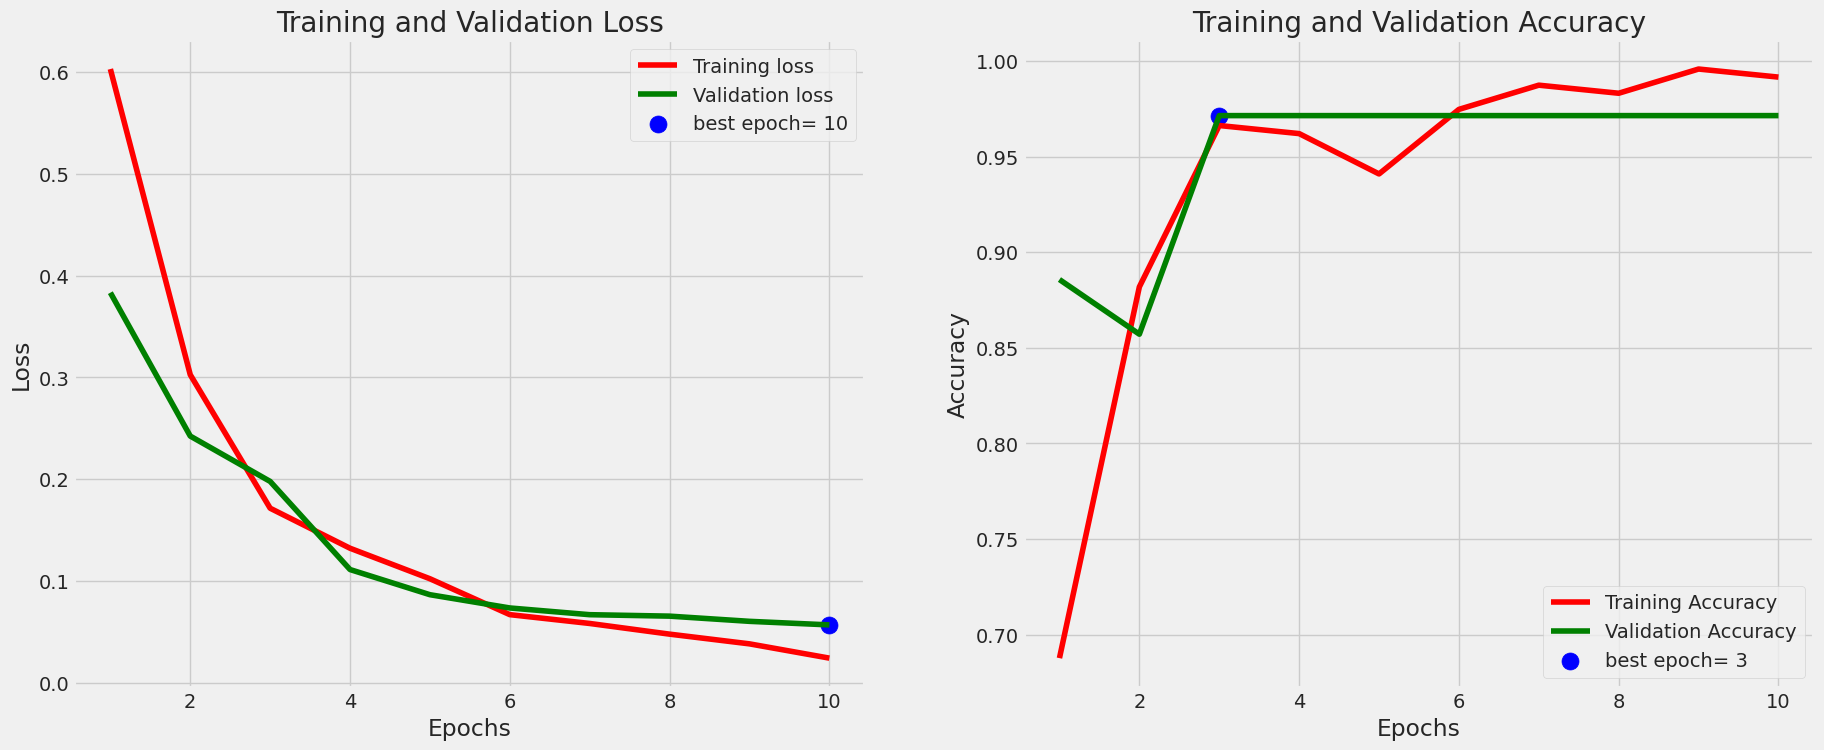

1/1 [==============================] - 55s 55s/step - loss: 0.1094 - accuracy: 0.9706
accuracy on the test set is 97.06 %



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
tr_plot(history,0)
save_dir=r'./'
subject='pest'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

## menampilkan hasil confusion matriks

1/1 [==============================] - 59s 59s/step


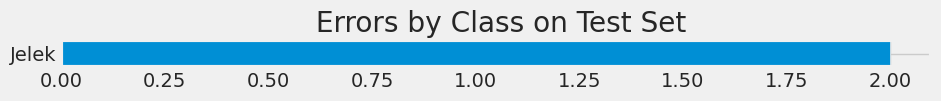

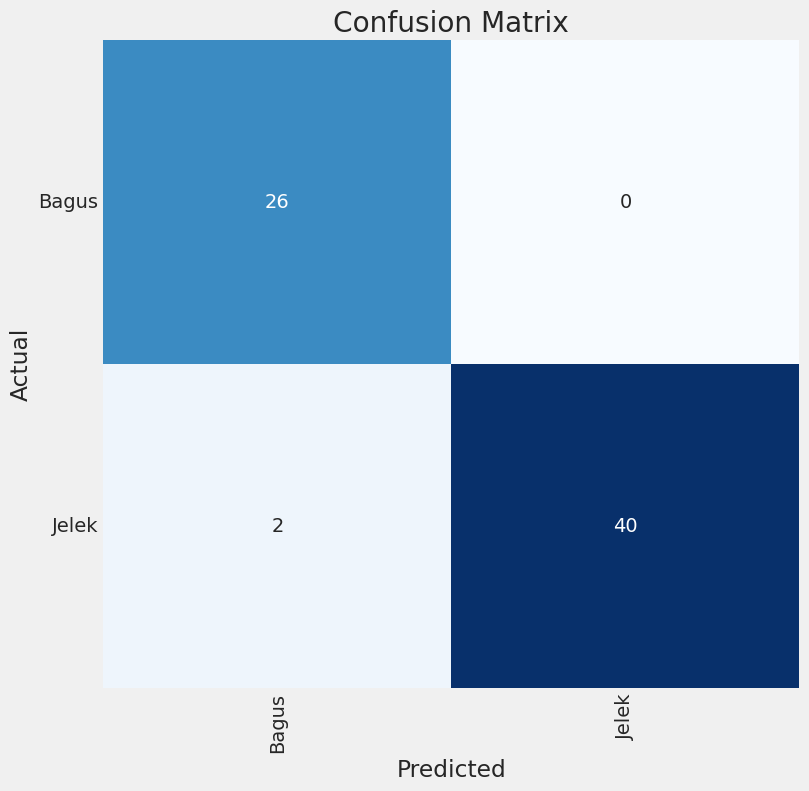

Classification Report:
----------------------
               precision    recall  f1-score   support

       Bagus       0.93      1.00      0.96        26
       Jelek       1.00      0.95      0.98        42

    accuracy                           0.97        68
   macro avg       0.96      0.98      0.97        68
weighted avg       0.97      0.97      0.97        68



In [ ]:
print_code=0
preds=model.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )

## testing model

Mounted at /content/drive


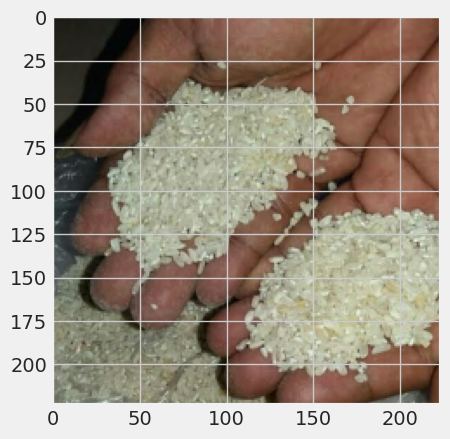

1/1 [==============================] - 1s 1s/step
Nilai yang diprediksi adalah: [0.4048093 0.5951907]
Label yang diprediksi adalah: 1 : Jelek


In [ ]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from google.colab import drive
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Path ke folder yang berisi model dan gambar
folder_path = '/content/drive/MyDrive/model/testing gambar/'

# List nama file gambar dalam folder
file_names = os.listdir(folder_path)

# Pilih satu gambar (misalnya, gambar ke-0)
selected_file = file_names[10]

# Baca gambar dari path yang benar
image_path = os.path.join(folder_path, selected_file)
image = imread(image_path) / 255.0
image = resize(image, (224, 224))  # Ubah ke ukuran yang diharapkan oleh model

# Tampilkan gambar
plt.imshow(image)
plt.show()

# Siapkan gambar untuk prediksi
input_image = np.expand_dims(image, axis=0)  # Tambahkan dimensi batch

# Lakukan prediksi
prediction = model.predict(input_image)[0]
predicted_label = np.argmax(prediction)
print("Nilai yang diprediksi adalah:", prediction)
print("Label yang diprediksi adalah:", predicted_label, ":", classes[predicted_label])

In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


In [ ]:
print(train_gen)

## save model

In [ ]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('klasifikasi_kualitasBeras9_VGG16Netv2.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
import shutil
from google.colab import drive
drive.mount('/content/gdrive')


# Ganti 'klasifikasi_kualitasBeras_VGG16Netv2.tflite' dengan nama file yang sesuai
shutil.copy('klasifikasi_kualitasBeras9_VGG16Netv2.tflite', '/content/gdrive/MyDrive/model/')

Mounted at /content/gdrive


'/content/gdrive/MyDrive/model/klasifikasi_kualitasBeras9_VGG16Netv2.tflite'